In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
from torch import nn, optim
from torchvision import datasets, transforms, models
from torchvision.ops import sigmoid_focal_loss
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"


In [2]:
# Use ImageNet normalization for pretrained ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# FYI: class_to_idx determines 0/1 mapping based on folder names (alphabetical)
print("class_to_idx:", train_dataset.class_to_idx)

# Build model
# (newer torchvision: weights=models.ViT_B_16_Weights.DEFAULT)
model = models.vit_b_16(pretrained=True).to(device)

# Freeze everything
for p in model.parameters():
    p.requires_grad = False

# Replace classifier with single-logit binary head
in_features = model.heads.head.in_features
model.heads.head = nn.Linear(in_features, 1).to(device)
model.heads.head.requires_grad_(True)

optimizer = optim.Adam(model.heads.head.parameters(), lr=1e-3)
def focal_criterion(logits, targets, alpha=0.25, gamma=2.0):
    # logits: (N,1), targets: float (N,1) with 0/1
    return sigmoid_focal_loss(
        inputs=logits,           # raw logits
        targets=targets,         # 0/1 floats, same shape
        alpha=alpha,
        gamma=gamma,
        reduction="mean"
    )
    

class_to_idx: {'Negative': 0, 'Positive': 1}


/home/ai-17/miniconda3/envs/mmdet/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ai-17/miniconda3/envs/mmdet/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
def train_one_epoch():
    model.train()
    running = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # (N,1)

        logits = model(imgs)   # (N,1)
        loss = focal_criterion(logits, labels, alpha=0.25, gamma=2.0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item() * imgs.size(0)
    return running / len(train_loader.dataset)

@torch.no_grad()
def evaluate():
    model.eval()
    correct = total = 0
    total_loss = 0.0
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        y = labels.float().unsqueeze(1).to(device)
        logits = model(imgs)
        total_loss += focal_criterion(logits, y).item() * imgs.size(0)

        preds = (torch.sigmoid(logits).squeeze(1) > 0.5).long()
        correct += (preds.cpu() == labels).sum().item()
        total += labels.size(0)
    return correct / total, total_loss / total

In [4]:
for epoch in range(10):
    train_loss = train_one_epoch()
    acc, val_loss = evaluate()
    print(f"epoch {epoch+1}: loss {train_loss:.4f} | acc {acc:.3f} | loss {val_loss:.3f}")

epoch 1: loss 0.0506 | acc 0.737 | loss 0.044
epoch 2: loss 0.0383 | acc 0.765 | loss 0.039
epoch 3: loss 0.0348 | acc 0.760 | loss 0.037
epoch 4: loss 0.0329 | acc 0.783 | loss 0.036
epoch 5: loss 0.0320 | acc 0.760 | loss 0.035
epoch 6: loss 0.0307 | acc 0.788 | loss 0.034
epoch 7: loss 0.0299 | acc 0.770 | loss 0.035
epoch 8: loss 0.0293 | acc 0.802 | loss 0.034
epoch 9: loss 0.0287 | acc 0.788 | loss 0.034
epoch 10: loss 0.0282 | acc 0.802 | loss 0.033


              precision    recall  f1-score   support

    Negative     0.8098    0.9490    0.8739       157
    Positive     0.7576    0.4167    0.5376        60

    accuracy                         0.8018       217
   macro avg     0.7837    0.6829    0.7058       217
weighted avg     0.7953    0.8018    0.7809       217

Confusion Matrix:
 [[149   8]
 [ 35  25]]


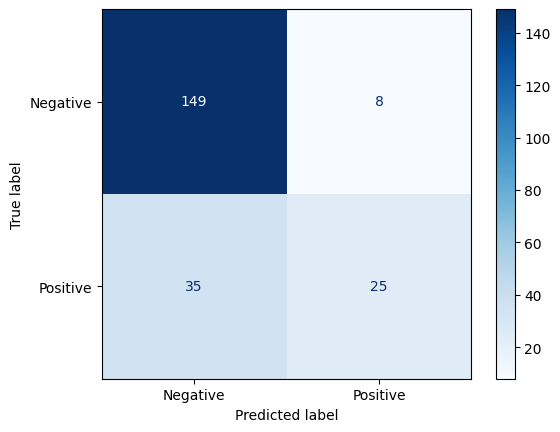

In [6]:
@torch.no_grad()
def evaluate_predictions():
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        probs = torch.sigmoid(logits).squeeze(1)
        preds = (probs > 0.5).long()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    return all_labels, all_preds, all_probs


# ---- Generate reports ----
labels, preds, probs = evaluate_predictions()

# Classification report (precision, recall, f1)
print(classification_report(labels, preds, target_names=train_dataset.classes, digits=4))

# Confusion matrix
cm = confusion_matrix(labels, preds)
print("Confusion Matrix:\n", cm)

# Optional: visualize it
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues")
plt.show()
